

# What makes a patient a no-show?
## A Brief Look through medical appointment data 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

<p> For this analysis, I will be using the No Show Appointments dataset, which is originally from Kaggle. It is a collection of information on over 100,000 medical appointments in Brazil. The data has basic information on the date of the appointment and when it was scheduled, along with various health characteristics of the patient such as, whether they have diabetes, or are an alcolohic, among others.</p>
    <p>So based off this information, can we predict whether a patient is more likely to be a no-show to his or her appointment? This analysis will serve to try to answer this question through observations gathered from the dataset, some of which will be...</p>
    <p>&nbsp; &nbsp;-Does age affect the likelhood of a patient being a no-show?
    <dd>&nbsp; &nbsp;-What about existing health conditions (Hypertension, diabetes, etc.)?</dd>
    <dd>&nbsp; &nbsp;-How does time between the scheduling of the appointment to its actual date, affect whether or not a patient will show up?</dt>

In [1]:
#Importing of necessary libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

Upon loading the necessary libraries, the first step is loading the dataset. I will also run a couple functions to help better understand the data, and assess what sort of cleaning will be needed in order to conduct proper analyses with it.

### General Properties

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None
          PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205 

> Some insights are readily apparant such as the average age of patients is around 23. The percentage of patients with hipertension, at 40%, appears fairly high in comparison to our other health metrics like diabetes and alcoholism, both at 26% and 17% respectively. But obviously the data needs to be checked for errors/oddities before making such conclusions (the -1 min in the age field for example). Also of note, there are no null values, so no replacing necessary. But most importantly, the No-show values (our dependent variable) is of the object data type, as yes-no values. In order to properly conduct this study, we need to modify this so they are binary integers, similar to our other values.

### Data Cleaning
<d>Let's take a look at each column and see if any others need cleaning

In [3]:
#First, I'll change the column headers to snake_case to avoid errors on my end as I work through the analysis

df.columns = ['patient_id', 'appointment_id', 'gender', 'scheduled_day', 'appointment_day',
              'age', 'neighborhood', 'scholarship', 'hypertension', 'diabetes',
              'alcoholism', 'handicap', 'sms_received', 'no_show']

__*patient_id & appointment_id*__
<br>Self-explanatory values. Not much manipulation other than making sure that each appointment has a unique id

In [4]:
df['appointment_id'].nunique()

110527

__*scheduled_day & appointment_day*__
<br>Also pretty self-explanatory values. Here, I want to convert both to the datetime format and then parse them into a column with the days between the scheduling and the actual appointment to see if there's any correlation to a no-show

In [5]:
#Conversion of the scheduled-appointment columns
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'], format='%Y-%m-%dT%H:%M:%SZ')
df['appointment_day'] = pd.to_datetime(df['appointment_day'], format='%Y-%m-%dT%H:%M:%SZ')

In [6]:
#Creation of new column 'hour_scheduled' for further analysis later
df['scheduled_hour'] = df['scheduled_day'].apply(lambda x: x.hour)

In [7]:
#Function to return the date from the time
def day(datetime_object):
    return datetime_object.date()

#Creation of new column 'days_between' as the difference between the day scheduled and actual appointment day
df['days_between'] = df['appointment_day'].apply(day) - df['scheduled_day'].apply(day)
#Change dtype to int
df['days_between'] = (df['days_between'].astype('timedelta64[D]')).astype(int)

In [8]:
#Now to create new column grouping the days_between into ranges (lettering to keep groups in order)
days_between_labels = pd.Series([
    'A: Same Day',
    'B: 1-3 Days',
    'C: 4-7 Days',
    'D: 8-14 Days',
    'E: 14-30 Days',
    'F: 31+ Days'
 ])
df['days_between_group'] = pd.cut(df['days_between'], bins = [-1, 0, 3, 7, 14, 30, 200],
                                 labels=days_between_labels)

__*gender*__
<br>Again, values speak for itself. I'll count up each value to see how it stacks up

In [9]:
df.gender.value_counts()

F    71840
M    38687
Name: gender, dtype: int64

__*age*__
<br> Let's group these into buckets in a new column to see how differently, if at all, no show patients are across age groups

In [10]:
df['generation'] = df['age'].apply(lambda x: min(int(x / 10), 9))
df['generation'].value_counts()

0    17476
5    15863
3    15171
4    14209
2    13699
1    12936
6    11876
7     5934
8     2946
9      417
Name: generation, dtype: int64

__*neighborhood*__
<br> This refers to the neighborhood of the hospital. No manipulation necessary

In [11]:
df['neighborhood'].nunique()

81

__*sms_recieved, scholarship, hypertension, diabetes, & alcoholism*__
<br> All of these fields are binary integers, 1: yes, 2: no. sms refers to whether a patient received a text reminder of their appointment or not, scholarship refers to a patient's healthcare status, and  the health characteristics represent whether a patient has each ailment or not

__*handicap*__
<br> This value adds up the number of ailments (scholarship status included). The only manipulation here will be to create a seperate column indicating if a patient as any ailment at all

In [12]:
df['is_handicapped'] = df['handicap'] > 0

__*no_show*__
<br> Our dependent variable. First we have to change it from a string value of 'yes' or 'no' to an int of 1 or 0, similar to our other health characteristics. Lastly, I will create masks for the numbers of no shows and shows to simplify my analysis

In [13]:
#Now to change the no-show variable from 'yes-no' to ints
df['no_show'] = df['no_show'].map({'Yes': 1, 'No': 0})

In [14]:
#Create masks
no_show = df.no_show == True
show = df.no_show == False

<a id='eda'></a>
## Exploratory Data Analysis

Now that the data is cleaned up to our liking, we are ready to explore it. Through statistic computation and visualizations, let's see if we can figure out how to best know if a patient will be a no show.

### Are men or women more likely to be a no show?

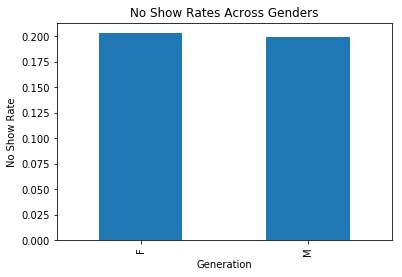

In [15]:
#Creation of bar chart showing relationship between variables with percentages to show just how close they are
df.groupby('gender').no_show.mean()
df.groupby('gender').no_show.mean().plot(kind='bar')
plt.title('No Show Rates Across Genders')
plt.xlabel('Generation')
plt.ylabel('No Show Rate');

>So almost identical really. Nothing to see here.

### What about age? Is this a factor?

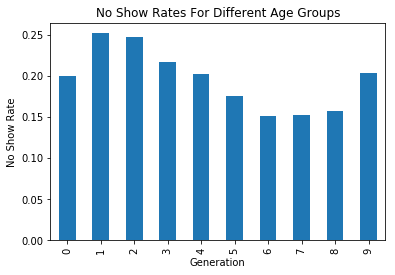

In [16]:
#Creation of bar chart showing relationship between variables
df.groupby('generation').no_show.mean().plot(kind='bar')
plt.title('No Show Rates For Different Age Groups')
plt.xlabel('Generation')
plt.ylabel('No Show Rate');

>So in general, the younger the patient, the more likely they are to miss their appointment, with the exception of the youngest group (ages 0-9). This is probably due to, in most cases, them being accompanied by their parents who have the control of them showing up or not.

### Does the day the appointment was scheduled in relation to the day of matter?

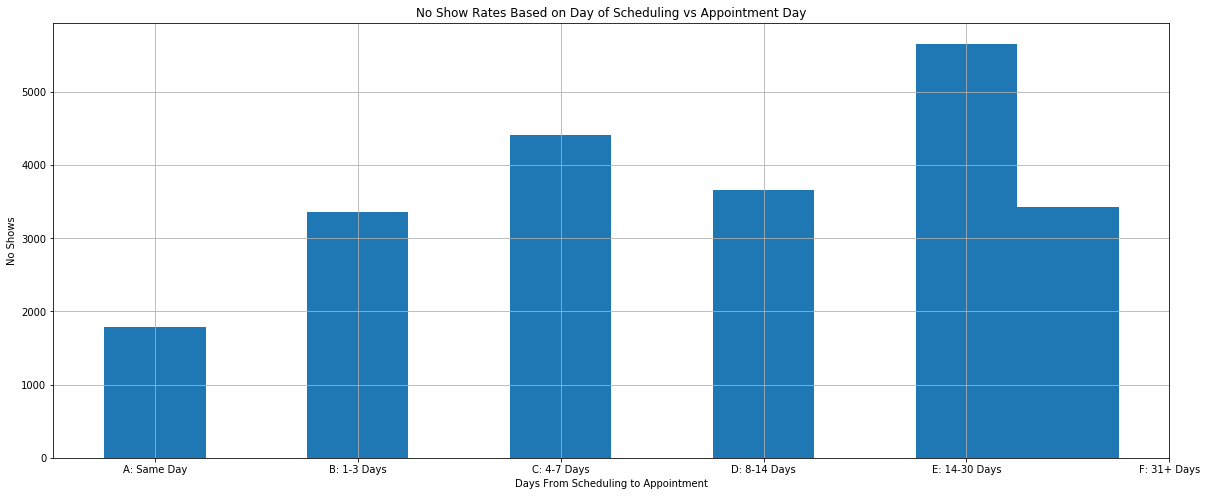

In [17]:
#Creation of histogram showing relationship between variables
df.days_between_group[no_show].hist(label='no show', figsize=(20, 8), align='left')
plt.title('No Show Rates Based on Day of Scheduling vs Appointment Day')
plt.xlabel('Days From Scheduling to Appointment')
plt.ylabel('No Shows');

>As one would expect, same day schedulings have the lowest no show rates. Also to no surprise, the further out a patient schedules the date, the more likely they are to not show for the appointment, with the exception of the 8-14 day window, which is a surprise.

### Does a text message notification increase or decrease the likelihood of a patient being a no show?

sms_received
0    0.167033
1    0.275745
Name: no_show, dtype: float64


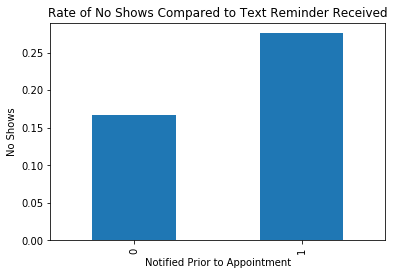

In [18]:
#Creation of bar chart showing relationship between variables
df.groupby('sms_received').no_show.mean().plot(kind='bar')
plt.title('Rate of No Shows Compared to Text Reminder Received')
plt.xlabel('Notified Prior to Appointment')
plt.ylabel('No Shows');
print(df.groupby('sms_received').no_show.mean())

>This is surprising. It appears patients who are notified via text message are significantly more likely to miss their appointment.

### How do health conditions affect a patient's likelihood of showing up for their appointment?

scholarship
0    0.198072
1    0.237363
Name: no_show, dtype: float64


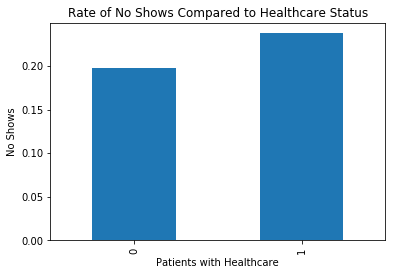

In [19]:
#Creation of bar chart showing relationship between variables
df.groupby('scholarship').no_show.mean().plot(kind='bar')
plt.title('Rate of No Shows Compared to Healthcare Status')
plt.xlabel('Patients with Healthcare')
plt.ylabel('No Shows');
print(df.groupby('scholarship').no_show.mean())

hypertension
0    0.209037
1    0.173020
Name: no_show, dtype: float64


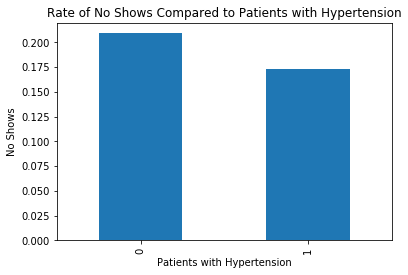

In [20]:
#Creation of bar chart showing relationship between variables
df.groupby('hypertension').no_show.mean().plot(kind='bar')
plt.title('Rate of No Shows Compared to Patients with Hypertension')
plt.xlabel('Patients with Hypertension')
plt.ylabel('No Shows');
print(df.groupby('hypertension').no_show.mean())

diabetes
0    0.203628
1    0.180033
Name: no_show, dtype: float64


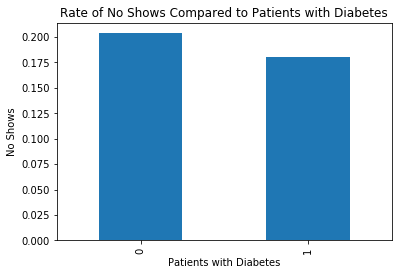

In [21]:
#Creation of bar chart showing relationship between variables
df.groupby('diabetes').no_show.mean().plot(kind='bar')
plt.title('Rate of No Shows Compared to Patients with Diabetes')
plt.xlabel('Patients with Diabetes')
plt.ylabel('No Shows');
print(df.groupby('diabetes').no_show.mean())

alcoholism
0    0.201946
1    0.201488
Name: no_show, dtype: float64


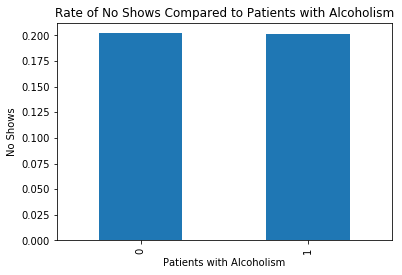

In [22]:
#Creation of bar chart showing relationship between variables
df.groupby('alcoholism').no_show.mean().plot(kind='bar')
plt.title('Rate of No Shows Compared to Patients with Alcoholism')
plt.xlabel('Patients with Alcoholism')
plt.ylabel('No Shows');
print(df.groupby('alcoholism').no_show.mean())

is_handicapped
False    0.202353
True     0.181615
Name: no_show, dtype: float64


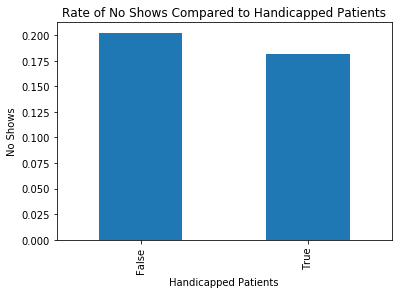

In [23]:
#Creation of bar chart showing relationship between variables
df.groupby('is_handicapped').no_show.mean().plot(kind='bar')
plt.title('Rate of No Shows Compared to Handicapped Patients')
plt.xlabel('Handicapped Patients')
plt.ylabel('No Shows');
print(df.groupby('is_handicapped').no_show.mean())

>So patients with healthcare are no shows more often than those without. Patients with hypertension and diabetes show up more regularly than those without either condition. There is no distinction between alcoholics and no shows. And in general, handicapped patients are slightly less frequently no shows.

<a id='conclusions'></a>
## Conclusions

So can we definitely predict if a patient will be a no show or not? After looking at the data across each column I think we can come to some conclusions that could better paint a picture of patients who are more likely to miss out on an appointment. Some of these findings are...
<p>&nbsp; &nbsp;-The further in advance a patient schedules an appointment, the more likely they are to miss it
    <dd>&nbsp; &nbsp;-Surprisingly, a reminder text not only doesn't work; it appears to have the opposite effect</dd>
    <dd>&nbsp; &nbsp;-Gender doesn't appear to matter but age does, as significantly more younger patients are no shows</dd>
    <dd>&nbsp; &nbsp;-Patients with healthcare are more often no shows than those without and in terms of ailments, patients with handicaps are less likely to be no shows</p>

The findings of this study provide some insight into predicting whether a patient is going to show up to an appointment or not. But it is only a small insight, given the size and small window of time of this dataset. To draw further, more in-depth conclusions, a larger more extensive dataset will be needed.